In [29]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from datetime import datetime, date, timedelta
import requests
from bs4 import BeautifulSoup
import csv


In [53]:
years = list(range(2010,2021))
variables = ['OZONE_ppm', 'CO', 'NOX', 'NO', 'NO2', 'SO2', 'PM25', 'PM10_S']

In [54]:
failed_downloads = {}
for var in variables:
    failed_downloads[var] = []


for year in years:
    for var in variables:
        
        # Skip data collection for vars in years that have already been pulled
        if os.path.exists(f'./Air Data/{year}/{year}_{var}.csv'):
                continue
                
        url = f'https://www.arb.ca.gov/aqmis2/display.php?download=y&year={year}&param={var}&units=007&statistic=DAVG&county_name=19-Los+Angeles&basin=--AIR+BASIN--&latitude=--PART+OF+STATE--&std15=&o3switch=new&hours=all&ptype=aqd&mon=&day=&report=AREA1YR&order=&btnsubmit=Update+Display'
        r = requests.get(url)
        
        # Only save as csv those pages that return data
        if (r.text.strip()):
            print(f'Saving csv for {var} in {year}')
            
            if not os.path.exists(f'./Air Data/{year}/'):
                os.makedirs(f'./Air Data/{year}/')
                
            with open(f'./Air Data/{year}/{year}_{var}.csv', 'wb') as f:
                f.write(r.content)
                f.close()
        else:
            failed_downloads[var].append(year)
            

Saving csv for PM25 in 2010
Saving csv for PM10_S in 2010
Saving csv for PM25 in 2011
Saving csv for PM10_S in 2011
Saving csv for PM25 in 2012
Saving csv for PM10_S in 2012
Saving csv for PM25 in 2013
Saving csv for PM10_S in 2013
Saving csv for PM25 in 2014
Saving csv for PM10_S in 2014
Saving csv for PM25 in 2015
Saving csv for PM10_S in 2015
Saving csv for PM25 in 2016
Saving csv for PM10_S in 2016
Saving csv for PM25 in 2017
Saving csv for PM10_S in 2017
Saving csv for PM25 in 2018
Saving csv for PM10_S in 2018
Saving csv for PM25 in 2019
Saving csv for PM10_S in 2019
Saving csv for PM25 in 2020
Saving csv for PM10_S in 2020


In [55]:
def get_values(file_path, datelist):
    df = pd.read_csv(file_path)
    
    df = df.iloc[list(range(31))]
    df.index = ["%02d" % int(x) for x in df['dom']]
    df = df.drop('dom', axis=1)
    cols = ["%02d" % x for x in range(1,13)]
    df = df.replace([" "],np.nan)
    df.columns = cols
    
    values = []
    for date in datelist:
        day = date[-2:]
        month = date[5:7]
        value = df.loc[day][month]
        values.append(value)
    return values

In [56]:
all_dates = []
data = {}

for var in variables:
    data[var] = []
    
for year in years:
    data_dir = f'./Air Data/{year}/'
    files = os.listdir(data_dir)

    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    datelist = pd.date_range(start_date, end_date).tolist()
    datelist = [date.to_pydatetime().strftime('%Y-%m-%d') for date in datelist]
    all_dates.extend(datelist)
    for file in files:
        if file == '.DS_Store':
            continue

        variable = [var for var in variables if f'{var}.csv' in file][0]
        data[variable].extend(get_values(data_dir+file, datelist))


In [57]:
data_df = pd.DataFrame(data)
data_df[data_df.columns] = data_df[data_df.columns].apply(pd.to_numeric)
# data_df.insert(0, 'Date', all_dates)
# data_df["Date"] = pd.to_datetime(all_dates)
data_df = data_df.set_index(pd.to_datetime(all_dates))
data_df

,OZONE_ppm,CO,NOX,NO,NO2,SO2,PM25,PM10_S
2010-01-01,0.028,1.087,0.069,0.043,0.028,0.004,26.8,23.0
2010-01-02,0.033,1.691,0.119,0.085,0.036,0.003,27.0,44.0
2010-01-03,0.031,1.248,0.092,0.058,0.036,0.003,14.4,18.5
2010-01-04,0.025,1.326,0.138,0.092,0.046,0.004,11.3,28.2
2010-01-05,0.023,1.486,0.183,0.132,0.050,0.004,13.8,34.0
...,...,...,...,...,...,...,...,...
2020-12-27,0.030,0.452,0.020,0.007,0.016,0.000,18.5,15.9
2020-12-28,0.034,0.370,0.033,0.015,0.018,0.000,12.3,9.6
2020-12-29,0.033,0.879,0.114,0.078,0.036,0.001,18.2,16.4
2020-12-30,0.039,1.362,0.169,0.125,0.044,0.001,22.8,19.4


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

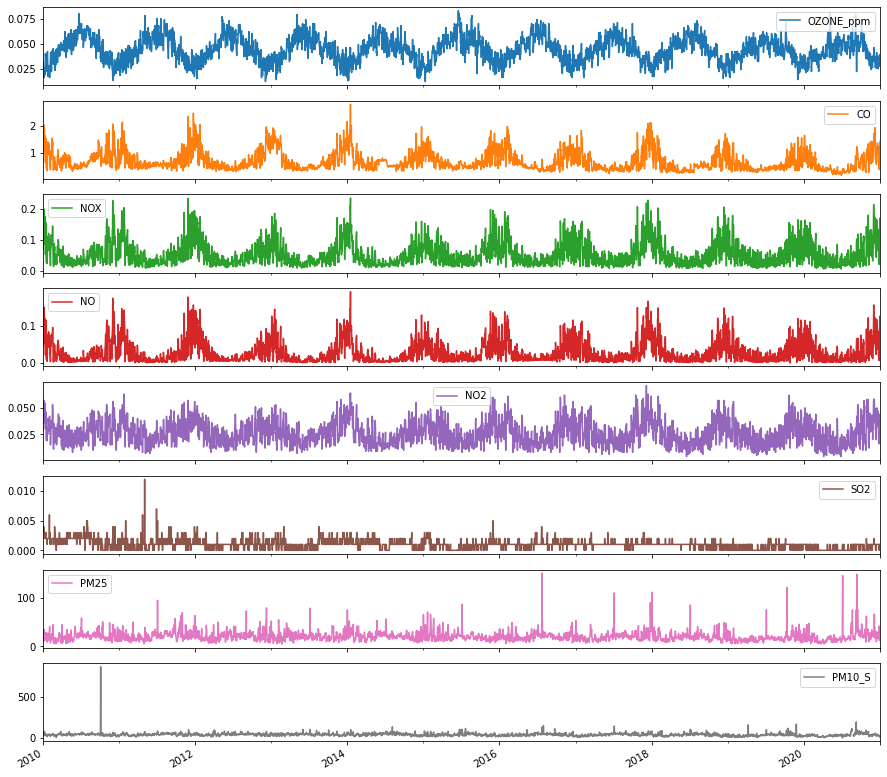

In [58]:
data_df.plot(subplots=True, figsize=(15, 15))

In [59]:
data_df.to_csv('air_data.csv')